In [1]:
%matplotlib inline


Audio Feature Augmentation
==========================


In [2]:
# When running this tutorial in Google Colab, install the required packages
# with the following.
# !pip install torchaudio librosa

import torch
import torchaudio
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.9.0+cu111
0.9.0


Preparing data and utility functions (skip this section)
--------------------------------------------------------




In [3]:
# @title Prepare data and utility functions. {display-mode: "form"}
# @markdown
# @markdown You do not need to look into this cell.
# @markdown Just execute once and you are good to go.
# @markdown
# @markdown In this tutorial, we will use a speech data from [VOiCES dataset](https://iqtlabs.github.io/voices/),
# @markdown which is licensed under Creative Commos BY 4.0.

# -------------------------------------------------------------------------------
# Preparation of data and helper functions.
# -------------------------------------------------------------------------------

import os

import librosa
import matplotlib.pyplot as plt
import requests


_SAMPLE_DIR = "_assets"

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

os.makedirs(_SAMPLE_DIR, exist_ok=True)


def _fetch_data():
    uri = [
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    ]
    for url, path in uri:
        with open(path, "wb") as file_:
            file_.write(requests.get(url).content)


_fetch_data()
# 데이터 불러오기
######################################################

def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects) # 토치.텐서 또는 파일에 SoX 효과 체인을 적용하고 토치.텐서로 로드


def get_speech_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)


def get_spectrogram(n_fft=400, win_len=None, hop_len=None, power=2.0):
    waveform, _ = get_speech_sample()
    spectrogram = T.Spectrogram(
        n_fft=n_fft,        # FFT의 크기
        win_length=win_len, # Window size
        hop_length=hop_len, # STFT window들 사이의 hop의 길이
        center=True,        # t번째 프레임이 t×hop_length시간의 중앙에 오도록 파형을 양쪽에 채울지 여부
        pad_mode="reflect", # center=True일때 패딩 방법을 제어하는 것
        power=power,        # Exponent for the magnitude spectrogram(0보다 커야함)
    )
    return spectrogram(waveform)
# 스펙토그램 추출하기
######################################################

def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

SpecAugment
-----------

`SpecAugment <https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html>`__
is a popular spectrogram augmentation technique.

``torchaudio`` implements :py:func:`torchaudio.transforms.TimeStretch`,
:py:func:`torchaudio.transforms.TimeMasking` and
:py:func:`torchaudio.transforms.FrequencyMasking`.




TimeStretch
-----------




/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:88: UserWarning: The use of pseudo complex type in spectrogram is now deprecated.Please migrate to native complex type by providing `return_complex=True`. Please refer to https://github.com/pytorch/audio/issues/1337 for more details about torchaudio's plan to migrate to native complex type.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:638: UserWarning: The use of pseudo complex type in `torchaudio.functional.phase_vocoder` and `torchaudio.transforms.TimeStretch` is now deprecated.Please migrate to native complex type by converting the input tensor with `torch.view_as_complex`. Please refer to https://github.com/pytorch/audio/issues/1337 for more details about torchaudio's plan to migrate to native complex type.
  warnings.warn(


TypeError: Invalid shape (201, 228, 2) for image data

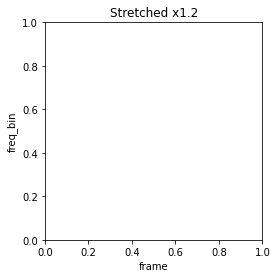

In [4]:
spec = get_spectrogram(power=None)
stretch = T.TimeStretch()

rate = 1.2 # TimeStretch를 재생속도라고 생각하면 좋을 것 같다.
spec_ = stretch(spec, rate)
plot_spectrogram(torch.abs(spec_[0]), title=f"Stretched x{rate}", aspect="equal", xmax=304)

plot_spectrogram(torch.abs(spec[0]), title="Original", aspect="equal", xmax=304)

rate = 0.9 # 0.9속도로 했기 때문에 frame 크기가 길어지는 것을 볼 수 있다.
spec_ = stretch(spec, rate)
plot_spectrogram(torch.abs(spec_[0]), title=f"Stretched x{rate}", aspect="equal", xmax=304)

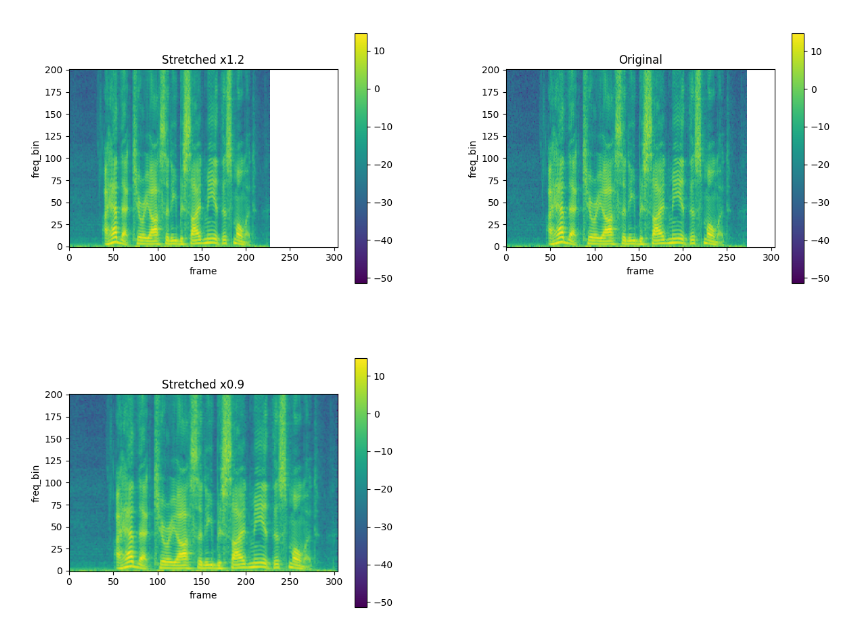

TimeMasking
-----------




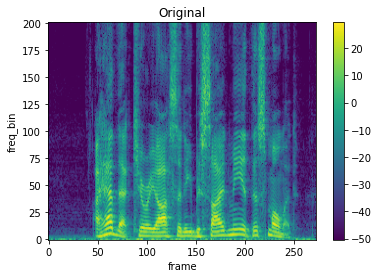

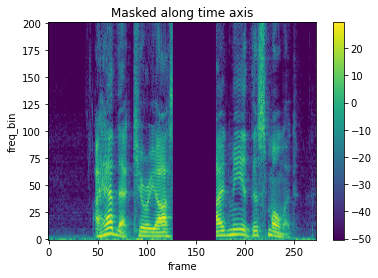

In [5]:
torch.random.manual_seed(4)

spec = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

masking = T.TimeMasking(time_mask_param=80)
# masking 가능한 최대 길이. [0, time_mask_param)에서 균일하게 샘플링된 인덱스.
spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along time axis")

FrequencyMasking
----------------




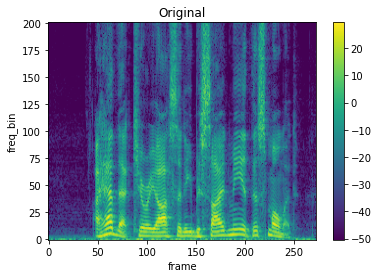

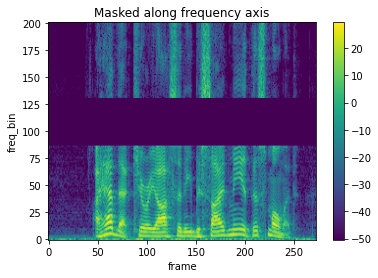

In [28]:
torch.random.manual_seed(4)
# 주파수를 마스킹하는 것

spec = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

masking = T.FrequencyMasking(freq_mask_param=80)
# masking 가능한 최대 길이. [0, freq_mask_param)에서 균일하게 샘플링된 인덱스
spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along frequency axis")

- 관련 파라미터
https://pytorch.org/audio/stable/transforms.html